# Momentum

## Import Library

In [1]:
import sys
sys.path.append('../../')

In [2]:

from config.constants import *
from backtesting import Backtest
from util.plot_equity import plot_equity_trades
from util.load_data import load_data
from Momentum import Momentum
from util.Save_result_return import save_to_csv




## Get Data

In [3]:
XAUUSD = load_data()

In [4]:
XAUUSD['D1'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5043 entries, 2007-01-01 to 2023-03-10
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5043 non-null   float64
 1   High    5043 non-null   float64
 2   Low     5043 non-null   float64
 3   Close   5043 non-null   float64
 4   Volume  5043 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 236.4 KB


## Define Strategy

In [4]:
strategy = Momentum

In [5]:
account_size = 1000

# Backtest each time frame

## TF D1

In [7]:
Backtest_D1 = Backtest(XAUUSD['D1'], strategy, cash=account_size, margin=1/100, )
result_D1 = Backtest_D1.run()
result_D1

C:\Users\Win10\AppData\Local\Temp\ipykernel_14400\3029564088.py:1: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  Backtest_D1 = Backtest(XAUUSD['D1'], strategy, cash=account_size, margin=1/100, )


Start                     2007-01-01 00:00:00
End                       2023-03-10 00:00:00
Duration                   5912 days 00:00:00
Exposure Time [%]                   88.082491
Equity Final [$]                     436.2294
Equity Peak [$]                     1318.3702
Return [%]                          -56.37706
Buy & Hold Return [%]               193.12344
Return (Ann.) [%]                   -4.060718
Volatility (Ann.) [%]               26.395583
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -77.248993
Avg. Drawdown [%]                   -6.845177
Max. Drawdown Duration     5323 days 00:00:00
Avg. Drawdown Duration      309 days 00:00:00
# Trades                                  500
Win Rate [%]                              9.2
Best Trade [%]                      17.196177
Worst Trade [%]                     -9.888391
Avg. Trade [%]                    

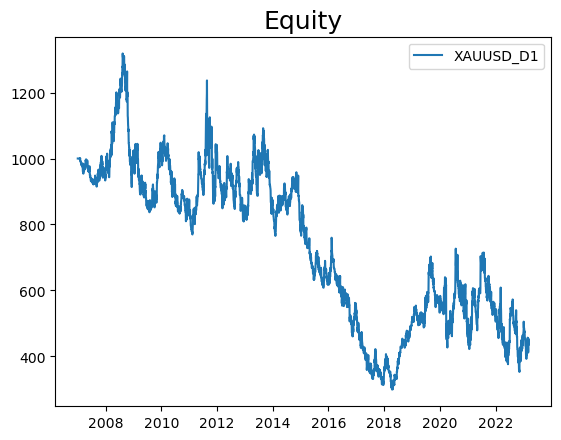

In [8]:
plot_equity_trades(result_D1['_equity_curve'], 'XAUUSD_D1' , account_size)

### Save output

In [19]:
save_to_csv(result_D1, '../../out/Technical_Strategy/Momentum/Backtest/result_D1.csv')  

## TF H4

In [6]:
Backtest_H4 = Backtest(XAUUSD['H4'], strategy,
                       cash=account_size, margin=1/100, )
result_H4 = Backtest_H4.run()
result_H4

C:\Users\Win10\AppData\Local\Temp\ipykernel_15348\4247094859.py:1: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  Backtest_H4 = Backtest(XAUUSD['H4'], strategy,


Start                     2007-01-01 00:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                   90.822298
Equity Final [$]                    3629.5531
Equity Peak [$]                     3684.7231
Return [%]                          262.95531
Buy & Hold Return [%]              193.329158
Return (Ann.) [%]                    6.653719
Volatility (Ann.) [%]               10.634673
Sharpe Ratio                         0.625663
Sortino Ratio                        1.068055
Calmar Ratio                         0.269253
Max. Drawdown [%]                  -24.711802
Avg. Drawdown [%]                   -1.118421
Max. Drawdown Duration      812 days 04:00:00
Avg. Drawdown Duration       18 days 20:00:00
# Trades                                 2157
Win Rate [%]                         11.49745
Best Trade [%]                      14.142366
Worst Trade [%]                     -5.204921
Avg. Trade [%]                    

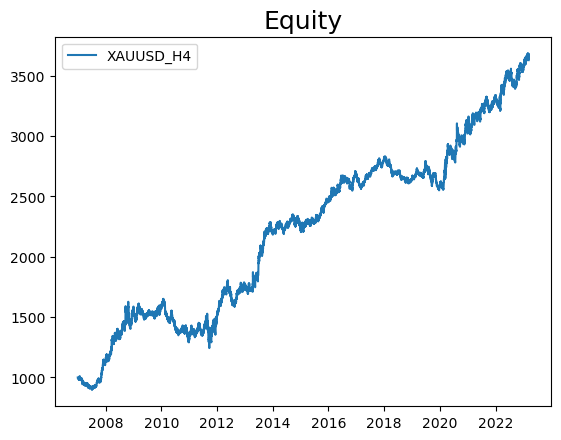

In [7]:
plot_equity_trades(result_H4['_equity_curve'], 'XAUUSD_H4', account_size)

### Save output

In [20]:
# save_to_csv(result_H4, '../../out/Technical_Strategy/Momentum/Backtest/result_H4.csv')  

## TF H1

In [13]:
Backtest_H1 = Backtest(XAUUSD['H1'], strategy,
                       cash=account_size, margin=1/100, )
result_H1 = Backtest_H1.run()
result_H1

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:00:00
Duration                   5912 days 17:00:00
Exposure Time [%]                   90.634379
Equity Final [$]                   21320.6571
Equity Peak [$]                    21503.7356
Return [%]                           6.603286
Buy & Hold Return [%]               193.27055
Return (Ann.) [%]                    0.320042
Volatility (Ann.) [%]                0.890553
Sharpe Ratio                         0.359374
Sortino Ratio                        0.558662
Calmar Ratio                         0.160217
Max. Drawdown [%]                   -1.997549
Avg. Drawdown [%]                   -0.102891
Max. Drawdown Duration     1066 days 20:00:00
Avg. Drawdown Duration       18 days 22:00:00
# Trades                                 8583
Win Rate [%]                        10.054759
Best Trade [%]                       7.135006
Worst Trade [%]                     -3.924052
Avg. Trade [%]                    

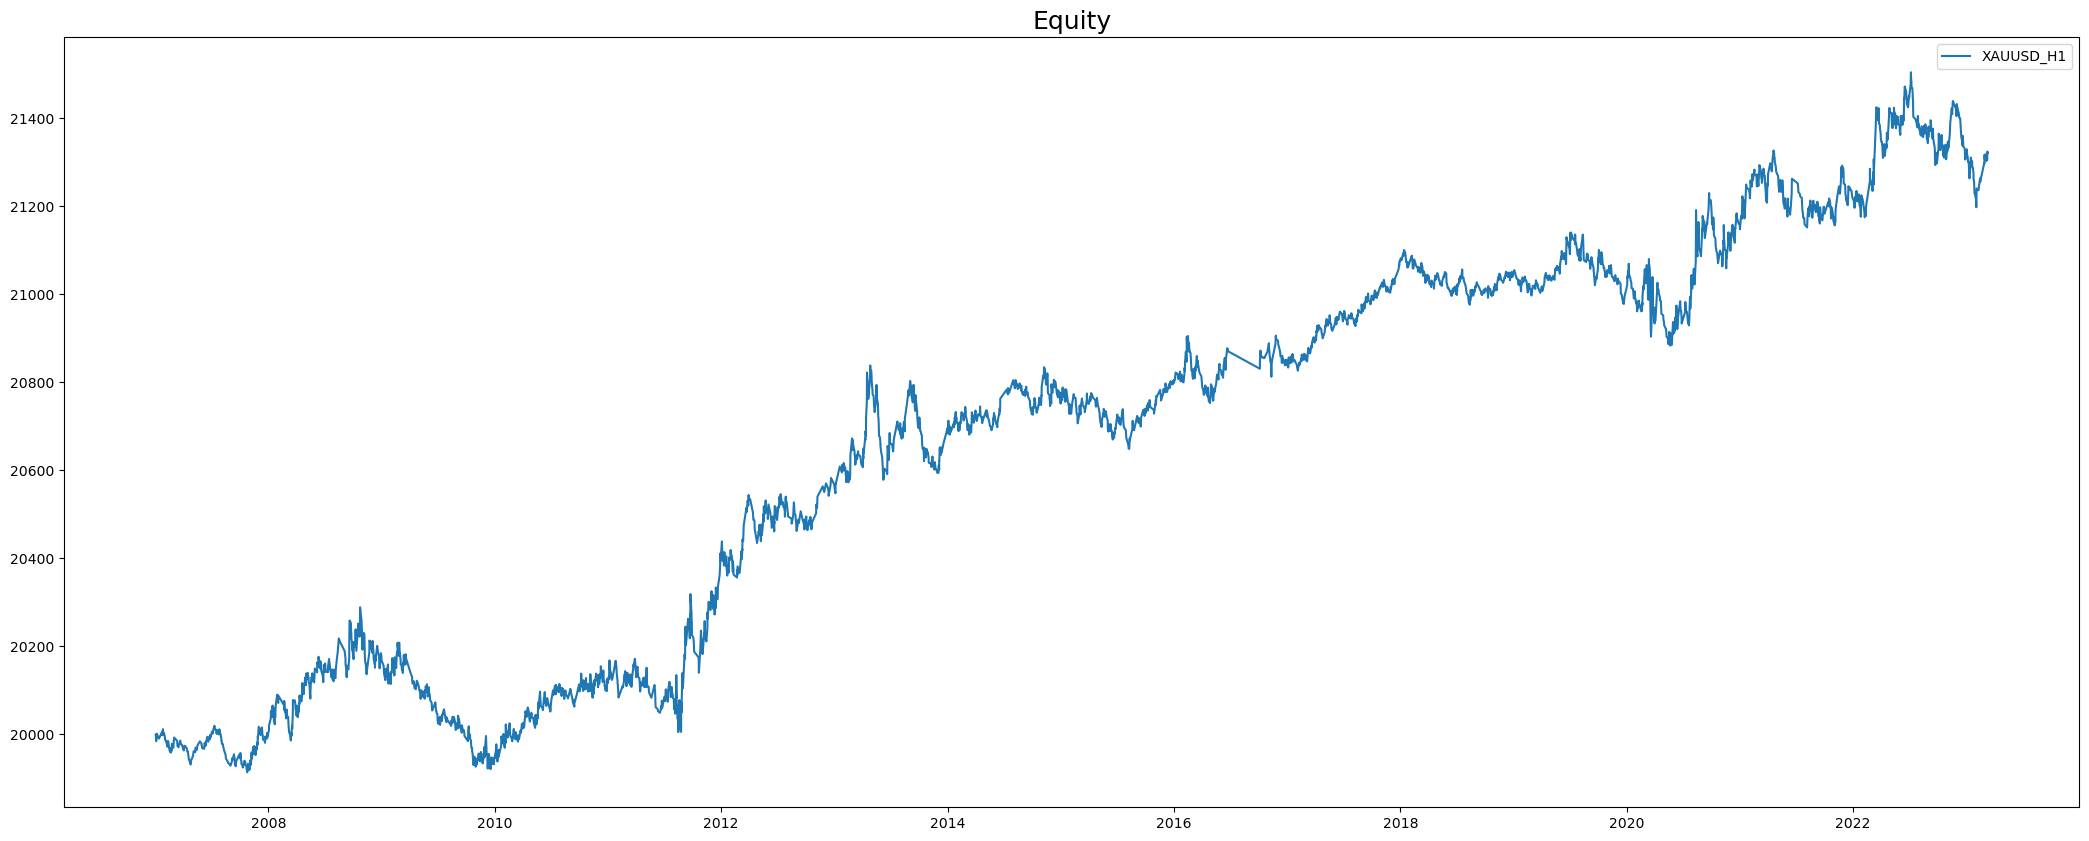

In [14]:
plot_equity_trades(result_H1['_trades'], 'XAUUSD_H1', account_size)

### Save output

In [21]:
# save_to_csv(result_H1, '../../out/Technical_Strategy/Momentum/Backtest/result_H1.csv')  

## TF M30 

In [7]:
Backtest_M30 = Backtest(XAUUSD['M30'], strategy,
                       cash=account_size, margin=1/100, )
result_M30 = Backtest_M30.run()
result_M30

Start                     2007-01-01 00:00:00
End                       2023-03-10 17:30:00
Duration                   5912 days 17:30:00
Exposure Time [%]                   90.764558
Equity Final [$]                   21072.5776
Equity Peak [$]                    21202.1717
Return [%]                           5.362888
Buy & Hold Return [%]              193.338852
Return (Ann.) [%]                    0.261849
Volatility (Ann.) [%]                0.896369
Sharpe Ratio                         0.292122
Sortino Ratio                        0.460776
Calmar Ratio                         0.118964
Max. Drawdown [%]                   -2.201083
Avg. Drawdown [%]                   -0.093889
Max. Drawdown Duration     2029 days 16:00:00
Avg. Drawdown Duration       21 days 23:03:00
# Trades                                16582
Win Rate [%]                         9.667109
Best Trade [%]                       6.046182
Worst Trade [%]                     -3.276153
Avg. Trade [%]                    

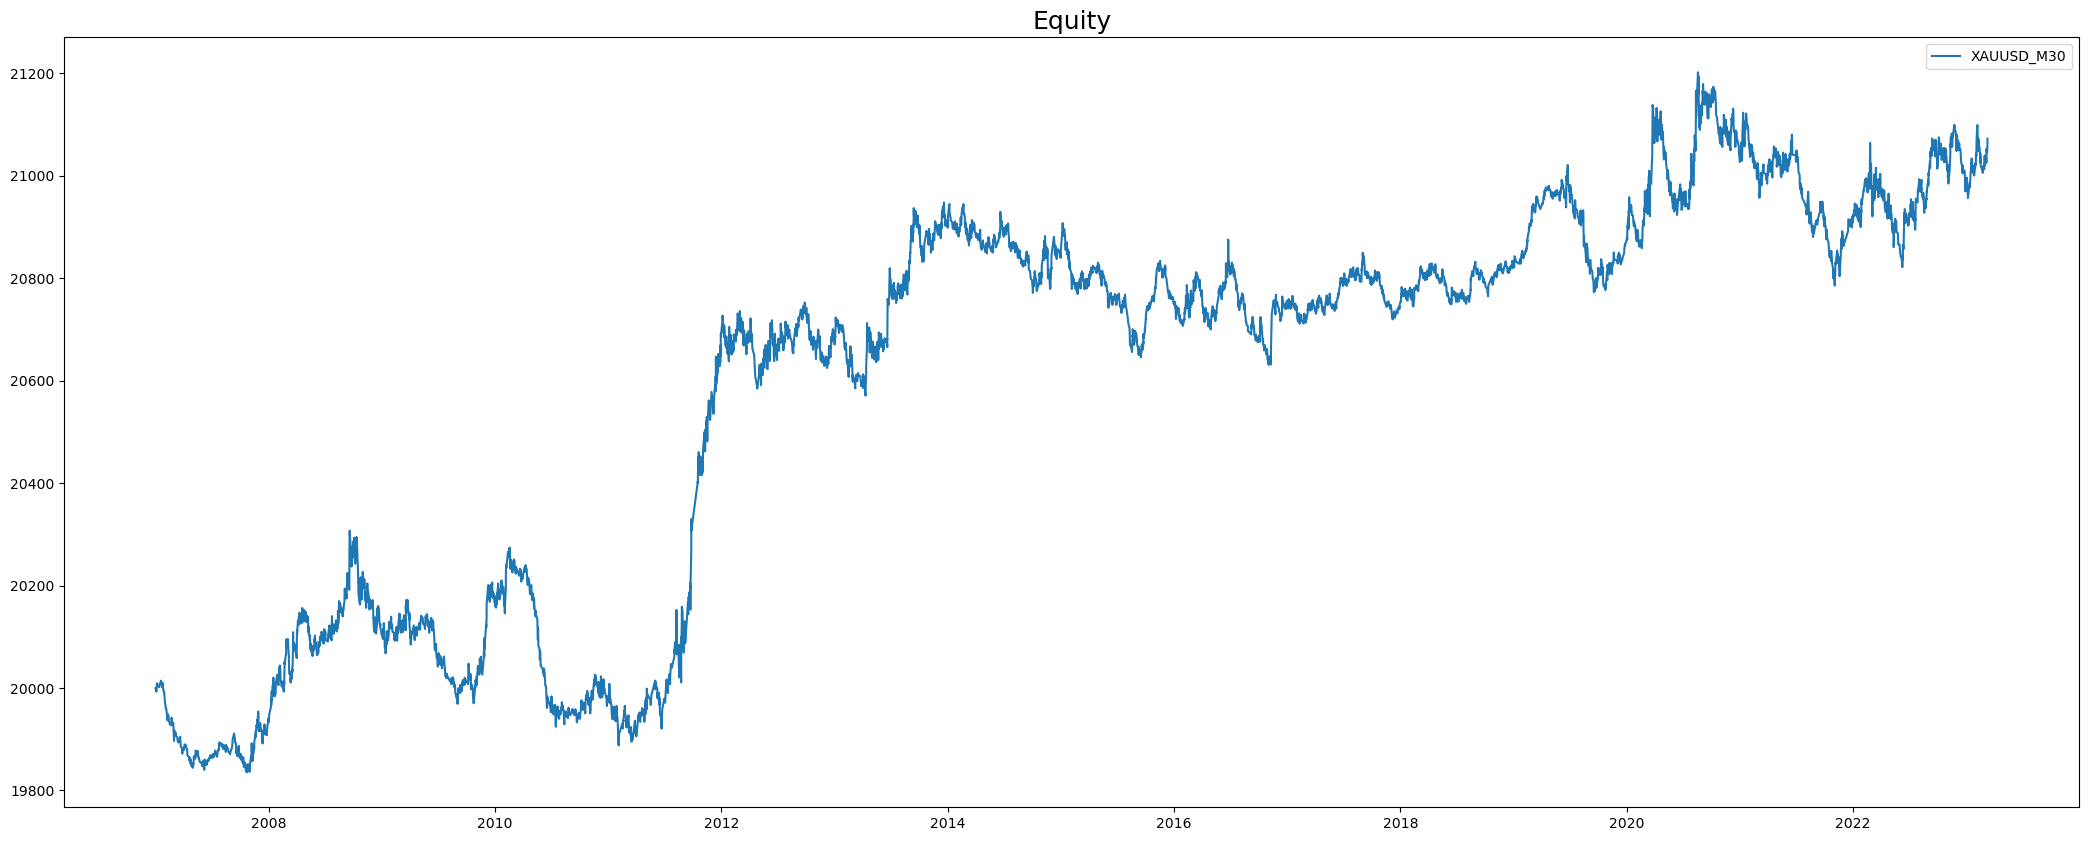

In [8]:
plot_equity_trades(result_M30['_trades'], 'XAUUSD_M30', account_size)

### Save output

In [9]:
# save_to_csv(result_M30, '../../out/Technical_Strategy/Momentum/Backtest/result_M30.csv')  